In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx

ox.__version__

'1.1.1'

In [2]:
state = 34
year = 2015

num_bins = 36
threshold = 10

In [3]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

def calculate_orientation_entropy(data, n):
    bin_counts = count_and_merge(n, data)
    entropy = stats.entropy(bin_counts)
    return entropy

def orientation_order(eta, max_ent, min_ent):
    # normalize it as a value between perfect_grid_entropy and max_entropy
    # then square it to approx linearize orientation_order's relationship with the
    # share of total bins with equal non-zero probabilities
    return 1 - ((eta - min_ent) / (max_ent - min_ent)) ** 2

In [4]:
url = f"https://www2.census.gov/geo/tiger/GENZ{year}/shp/cb_{year}_{state}_bg_500k.zip"

<AxesSubplot:>

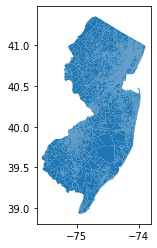

In [5]:
jersey = gpd.read_file(url)
jersey.geometry.plot()

In [6]:
from scipy import stats

min_bins = 4
perfect_grid = [1] * min_bins + [0] * (num_bins - min_bins)
perfect_grid_entropy = stats.entropy(perfect_grid)
perfect_grid_entropy

max_entropy = np.log(num_bins)

In [7]:
import warnings
warnings.filterwarnings("ignore") 

In [43]:
%%time

misses = np.empty(0)
errors = np.empty(0)

results = {}

counter = 0

for i in jersey.index[(jersey.shape[0] // 2):]:
    
    counter += 1
    if (counter % 100) == 0: 
        print(f"misses: {len(misses)} // i: {counter}")
    
    geoid = jersey['GEOID'][i]
    
    poly = jersey.geometry[i].buffer(0.0001)
    
    try: 
        G = ox.graph.graph_from_polygon(polygon=poly,
                                        network_type='drive')  
    except: 
        misses = np.append(misses, geoid)
        pass
    
    n, e = ox.graph_to_gdfs(ox.add_edge_bearings(G))
    
    n_stats = n.agg({'street_count': ['count', 'mean']})
    e_stats = e.agg({'length': ['sum', 'count', 'mean']})
    
    bearings = e[e['length'] > threshold]['bearing']
    orientation_entropy = calculate_orientation_entropy(bearings.dropna(), num_bins)
    
    net_stats = ox.stats.basic_stats(G)
    
    order = orientation_order(orientation_entropy, max_ent=max_entropy, min_ent=perfect_grid_entropy)
    
    try: 
        inter = net_stats['streets_per_node_proportions'][4]
    except:
        inter = 0
        errors = np.append(errors, geoid)
        
    lined = 1 / net_stats['circuity_avg']
    
    results[geoid] = {'node_count': n_stats.iloc[0, 0],
                      'typical_intersection': n_stats.iloc[1, 0],
                      'edge_length': e_stats.iloc[2, 0],
                      'edge_count': e_stats.iloc[1, 0],
                      'edge_total': e_stats.iloc[0, 0],
                      'orientation_order': order,
                      'prop_4way': inter,
                      'straightness': lined,
                      'grid_index': stats.gmean([order, inter, lined])}

misses: 0 // i: 100
misses: 1 // i: 200
misses: 3 // i: 300
misses: 5 // i: 400
misses: 5 // i: 500
misses: 7 // i: 600
misses: 7 // i: 700
misses: 8 // i: 800
misses: 8 // i: 900
misses: 59 // i: 1000
misses: 59 // i: 1100
misses: 59 // i: 1200
misses: 62 // i: 1300
misses: 62 // i: 1400
misses: 63 // i: 1500
misses: 64 // i: 1600
misses: 64 // i: 1700
misses: 65 // i: 1800
misses: 67 // i: 1900
misses: 68 // i: 2000
misses: 69 // i: 2100
misses: 72 // i: 2200
misses: 73 // i: 2300
misses: 73 // i: 2400
misses: 75 // i: 2500
misses: 75 // i: 2600
misses: 76 // i: 2700
misses: 76 // i: 2800
misses: 76 // i: 2900
misses: 77 // i: 3000
misses: 78 // i: 3100
CPU times: user 18min 34s, sys: 14.7 s, total: 18min 49s
Wall time: 15h 25min 35s


In [11]:
print(counter)
print(jersey.shape[0])

3159
6318


In [41]:
# b1 = pd.DataFrame(results).T.reset_index()
# b1.to_csv("nj_b1.csv")

In [44]:
# b2 = pd.DataFrame(results).T.reset_index()
# b2.to_csv("nj_b2.csv")

In [52]:
results = pd.concat([b1, b2])

In [56]:
right = results
left = jersey.merge(right, how='left', left_on='GEOID', right_on='index').drop(['index'], axis=1)

In [57]:
right.head()

,index,node_count,typical_intersection,edge_length,edge_count,edge_total,orientation_order,prop_4way,straightness,grid_index
0,340010025003,31.0,3.483871,101.634707,75.0,7622.603,0.997371,0.483871,0.999208,0.784177
1,340258006012,41.0,2.682927,100.548362,94.0,9451.546,0.614082,0.268293,0.975958,0.543779
2,340258058004,62.0,3.096774,86.728407,123.0,10667.594,0.537693,0.225806,0.989465,0.493428
3,340130105002,22.0,3.363636,119.107000,52.0,6193.564,0.843095,0.363636,0.996953,0.673606
4,340130049002,18.0,3.333333,109.014156,45.0,4905.637,0.898501,0.333333,0.999918,0.669043


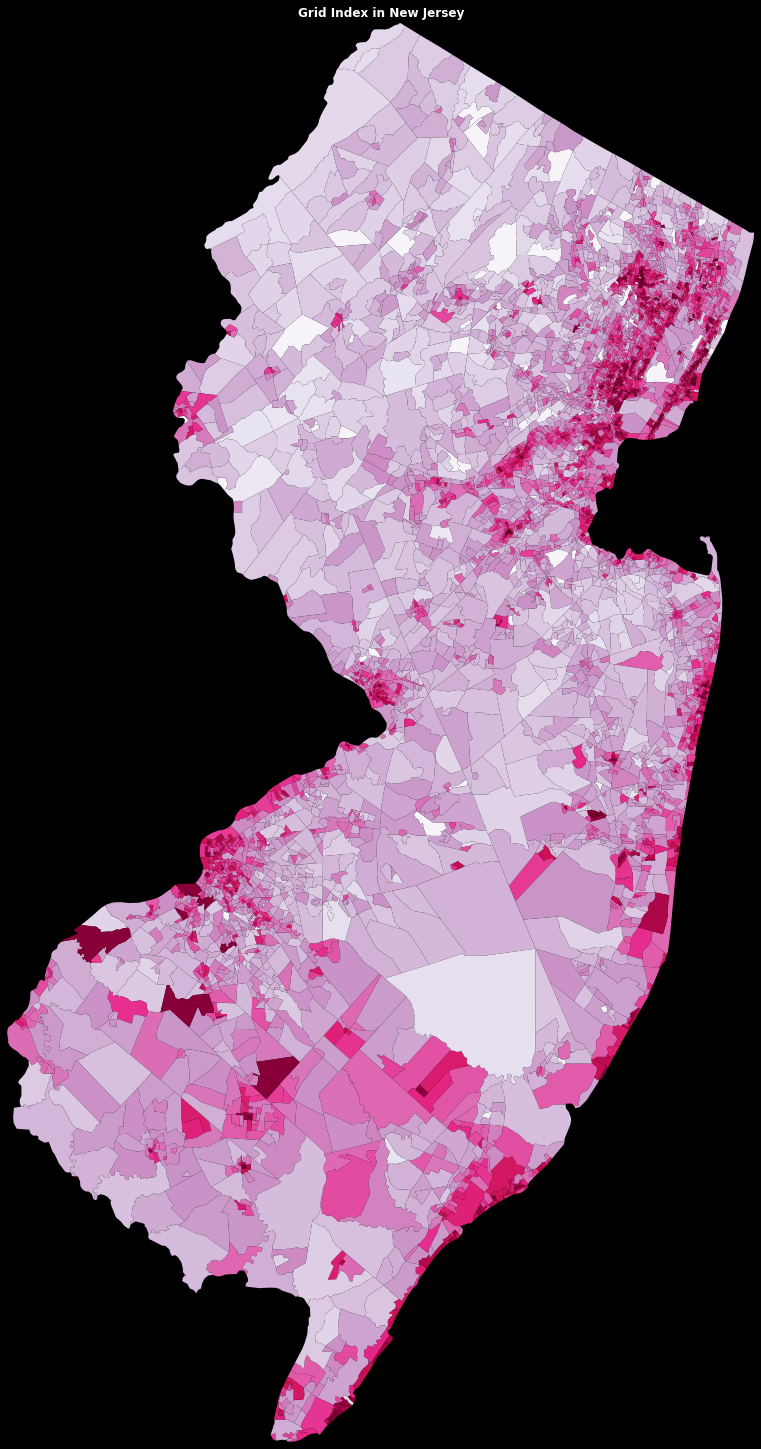

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

left = left.to_crs('EPSG:6526')
left.plot('grid_index', ax=ax, cmap='PuRd', lw=0.05)
    
ax.set_title("Grid Index in New Jersey", color='w', weight='bold')

ax.margins(0)
ax.axis('off')
    
fig.savefig('grid-index_NJ.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [59]:
left[['GEOID', 'node_count', 'typical_intersection', 'edge_count', 'edge_length',
      'straightness', 'orientation_order', 'prop_4way', 'grid_index']].to_csv("grid-index_NJ.csv")

In [60]:
%%time
buildings = gpd.read_file("NewJersey_MBP_CNTY.gpkg")

CPU times: user 1min 15s, sys: 2.12 s, total: 1min 17s
Wall time: 1min 17s


In [61]:
buildings = buildings.to_crs('EPSG:6526')

In [62]:
buildings['area'] = buildings.geometry.area
buildings['peri'] = buildings.geometry.length

In [63]:
import math
buildings['isoperi'] = (buildings['area'] * (4 * math.pi)) / (buildings['peri'] ** 2)

In [64]:
buildings.head()

,STATEFP,COUNTYFP,GEOID,NAME,geometry,area,peri,isoperi
0,34,037,34037,Sussex,"POLYGON ((127771.510 241443.448, 127777.830 24...",46.955681,27.480520,0.781355
1,34,037,34037,Sussex,"POLYGON ((127773.100 241468.428, 127762.606 24...",160.243915,50.635956,0.785368
2,34,037,34037,Sussex,"POLYGON ((127416.138 242655.137, 127429.527 24...",303.569666,70.852523,0.759902
3,34,037,34037,Sussex,"POLYGON ((127560.178 242727.984, 127554.733 24...",101.786746,40.686462,0.772683
4,34,037,34037,Sussex,"POLYGON ((128040.275 242965.278, 128030.025 24...",326.526138,80.580794,0.631924


In [65]:
jersey = jersey.to_crs('EPSG:6526')

In [66]:
jersey.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,34,001,002500,3,1500000US340010025003,340010025003,3,BG,220252,73902,"POLYGON ((156633.865 58927.358, 157390.944 593..."
1,34,025,800601,2,1500000US340258006012,340258006012,2,BG,571071,11711,"POLYGON ((182915.329 178632.447, 182993.659 17..."
2,34,025,805800,4,1500000US340258058004,340258058004,4,BG,374636,298526,"POLYGON ((193976.527 163111.404, 194446.363 16..."
3,34,013,010500,2,1500000US340130105002,340130105002,2,BG,232283,0,"POLYGON ((173721.501 215162.809, 173830.590 21..."
4,34,013,004900,2,1500000US340130049002,340130049002,2,BG,105019,0,"POLYGON ((174611.609 208088.518, 174750.200 20..."


In [67]:
centroids = gpd.GeoDataFrame(buildings[['peri', 'area', 'isoperi']], 
                             geometry=buildings.centroid, crs="EPSG:6526")

In [69]:
joined = gpd.sjoin(jersey, centroids, 
                   how="left", 
                   op='intersects').groupby('GEOID', 
                                            as_index=False).agg({'peri': ['mean'],
                                                                 'area': ['mean', 'sum'],
                                                                 'isoperi': ['mean'],
                                                                 'index_right': ['count']})

joined.columns = [f'{i}_{j}' for i, j in joined.columns]

joined = joined.rename(columns={"GEOID_": "GEOID",
                                "index_right_count": "geometry_count"})
joined.head()

,GEOID,peri_mean,area_mean,area_sum,isoperi_mean,geometry_count
0,340010001001,56.848924,225.015398,58729.018853,0.705643,261
1,340010001002,53.595287,173.742595,46910.500602,0.700424,270
2,340010002001,53.166776,192.359075,32701.042779,0.724669,170
3,340010002002,52.045814,159.540790,34779.892154,0.717300,218
4,340010002003,57.028956,204.496948,46420.807111,0.718780,227


In [70]:
joined = joined.merge(jersey, how='left', left_on='GEOID', right_on='GEOID')
joined = gpd.GeoDataFrame(joined, geometry=joined.geometry, crs='EPSG:26985')

joined.head()

,GEOID,peri_mean,area_mean,area_sum,isoperi_mean,geometry_count,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry
0,340010001001,56.848924,225.015398,58729.018853,0.705643,261,34,001,000100,1,1500000US340010001001,1,BG,764226,231171,"POLYGON ((153199.901 58529.433, 153080.774 586..."
1,340010001002,53.595287,173.742595,46910.500602,0.700424,270,34,001,000100,2,1500000US340010001002,2,BG,924539,250098,"POLYGON ((152743.584 58565.671, 153046.171 585..."
2,340010002001,53.166776,192.359075,32701.042779,0.724669,170,34,001,000200,1,1500000US340010002001,1,BG,214489,646084,"POLYGON ((153377.175 57516.420, 153522.333 572..."
3,340010002002,52.045814,159.540790,34779.892154,0.717300,218,34,001,000200,2,1500000US340010002002,2,BG,145544,14525,"POLYGON ((153060.149 57366.646, 153379.034 575..."
4,340010002003,57.028956,204.496948,46420.807111,0.718780,227,34,001,000200,3,1500000US340010002003,3,BG,163297,9687,"POLYGON ((152774.193 57070.361, 152940.654 572..."


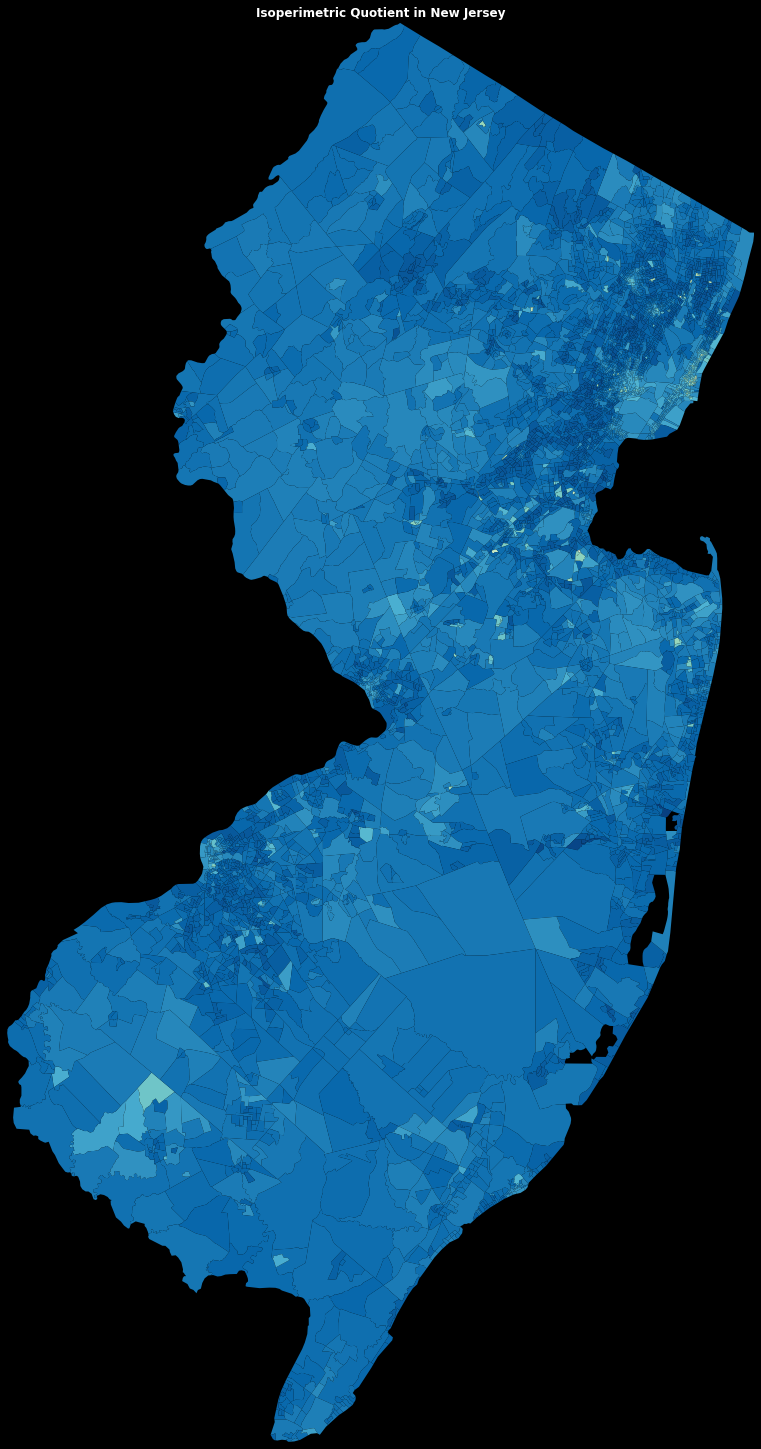

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

joined.to_crs('EPSG:6526')
joined.plot('isoperi_mean', ax=ax, cmap='GnBu', lw=0.05)
    
ax.set_title("Isoperimetric Quotient in New Jersey", color='w', weight='bold')

ax.margins(0)
ax.axis('off')
    
fig.savefig('isoperimetric-quotient_NJ.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [72]:
joined['area_normed'] = joined['area_sum'] / joined.geometry.area

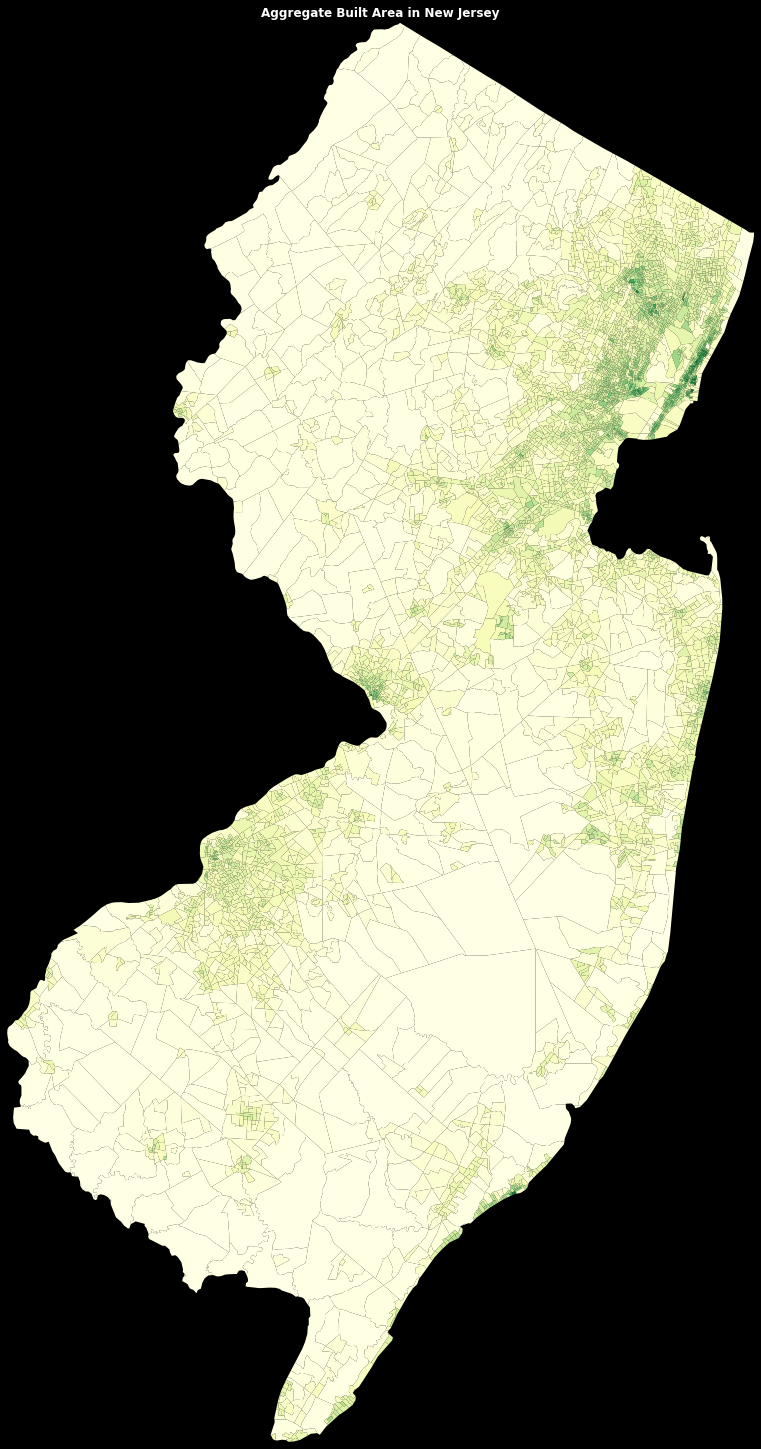

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

 

joined.to_crs('EPSG:6526')
joined.plot('area_normed', ax=ax, cmap='YlGn', lw=0.05)
    
ax.set_title("Aggregate Built Area in New Jersey", color='w', weight='bold')

ax.margins(0)
ax.axis('off')
    
fig.savefig('built-area_NJ.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [74]:
joined[['GEOID', 
        'peri_mean', 
        'area_mean', 
        'area_sum', 
        'area_normed', 
        'geometry_count', 
        'isoperi_mean']].merge(left[['GEOID', 'node_count', 'typical_intersection', 'edge_count', 'edge_length',
                                     'straightness', 'orientation_order', 'prop_4way', 'grid_index']], 
                               left_on='GEOID', right_on='GEOID', 
                               how='left').to_csv("area_characteristics_NJ.csv")